# Measuring the flux of the CO line

In the present notebook, we use the data retrieved of the detected CO line from the `mapping` and fit a Gaussian profile to measure the flux of the line.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit as cft
from scipy.optimize import minimize as mz
import scipy.integrate as inte
from astropy.cosmology import Planck18 as cosmo
import astropy.constants as con
import astropy.units as u

First, let's see how the data looks like...

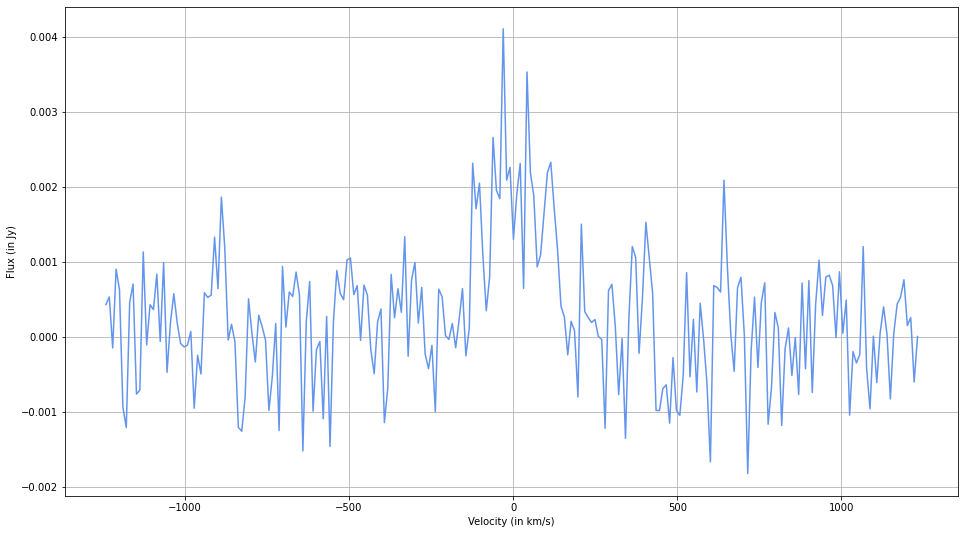

In [2]:
velo, flx = np.loadtxt(os.getcwd() + '/Counterimage.dat', usecols=(0,2), unpack=True)
plt.figure(figsize=(16,9))
plt.plot(velo, flx, color='cornflowerblue')
plt.xlabel('Velocity (in km/s)')
plt.ylabel('Flux (in Jy)')
plt.grid()
plt.show()

Well, it looks like kinda a line -- a rough Gaussian profile. We want to fit a Gaussian to this data to find the flux at the central velocity. First let's define a Gaussian function,

In [3]:
def gaus(x, mu, sig, const, aa):
    yy = np.exp(-0.5*((x-mu)/sig)**2)
    zz = aa*yy + const
    return zz

We now use `scipy.optimize.minimize` function to fit the Gaussian to the data. For that, we need a likelihood function which we can minimize.

In [4]:
def min_log_likelihood(x):
    model = gaus(velo, x[0], x[1], x[2], x[3])
    chi2 = (flx - model)
    chi22 = np.sum(chi2**2)
    yy = 0.5*chi22
    return yy

xinit = np.array([0, 200, 0, 0])

# Minimizing log likelihood
soln = mz(min_log_likelihood, xinit, method='L-BFGS-B')
print(soln)

      fun: 7.251384949009688e-05
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.27004830e-09,  8.79193094e-08, -1.08420217e-11, -1.08420217e-11])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 25
      nit: 3
   status: 0
  success: True
        x: array([-9.54713696e-11,  2.00000000e+02, -2.38472943e-05,  1.43448207e-03])


Let's see how the fits looks like...

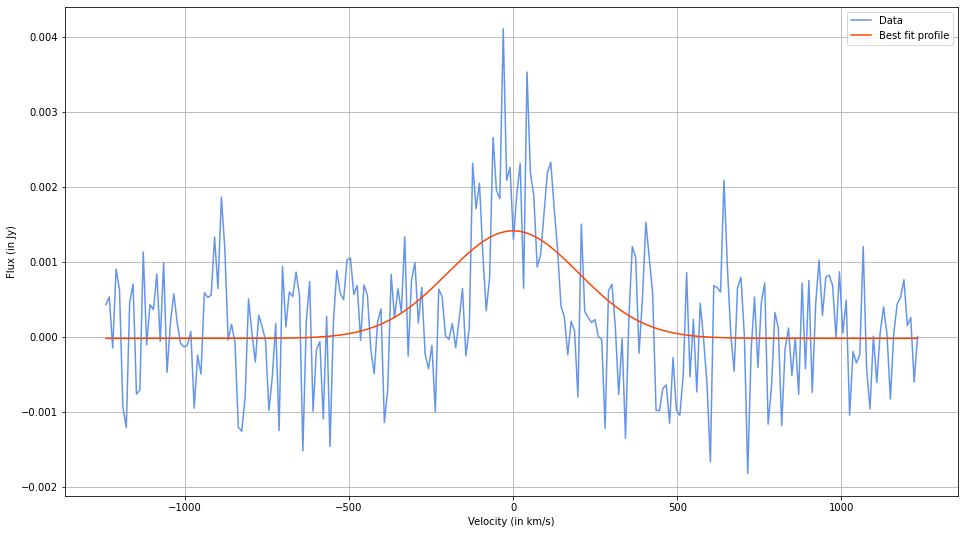

In [5]:
velo1 = np.linspace(np.min(velo), np.max(velo), 1000)
gaus1 = gaus(velo1, soln.x[0], soln.x[1], soln.x[2], soln.x[3])

plt.figure(figsize=(16,9))
plt.plot(velo, flx, color='cornflowerblue', label='Data')
plt.plot(velo1, gaus1, color='orangered', label='Best fit profile')
plt.xlabel('Velocity (in km/s)')
plt.ylabel('Flux (in Jy)')
plt.legend(loc='best')
plt.grid()
plt.show()

Well, it seems like a good Gaussian fit. We can find the flux by measuring the total area under the curve of the fitted Gaussian as follows:

In [6]:
fl11 = inte.simps(gaus1, velo1)
print('Flux density (in Jy km s-1): {:.4}'.format(fl11))

Flux density (in Jy km s-1): 0.6602


Sounds reasonable to me. Now we can use this flux to find the molecular gas mass of the galaxy. We proceed as follows:

We use a formula from Solomon et al. (1997) to calculate the CO luminosity from the measured flux density:

$$ L'_{CO} = 3.25 \times 10^7 S_{CO}\Delta V \nu_{obs}^{-2} D_L^2 (1+z)^{-3}$$

with $S_{CO}\Delta V$ in $Jy \ km \ s^{-1}$, $\nu_{obs}$ in $GHz$ and $D_L$ (which is luminosity distance -- we calculated this from the `Planck18` cosmology from `astropy.cosmology` module) in $Mpc$. From the data of the observations, we find that the observed frequency is $226.432945 \ GHz$ and the redshift is $1.036$. Using the usual formula of the doppler shift, we can compute the rest frame frequency of the observation:

$$\nu_{rest} = (1+z)*\nu_{abs} = (1+1.036)*226.432945 = 461.01747602 \ GHz$$

which is the frequency of CO (4-3) emission line.

First, let us calculate the CO luminosity,

In [7]:
redshift = 1.036
dl = (cosmo.luminosity_distance(redshift)).value
freq = 226.432945

lco = 3.25e7*fl11*(freq**-2)*dl*dl*((1+redshift)**-3)
print('CO (4-3) luminosity (in K km s-1 pc2): {:.4}'.format(lco))

CO (4-3) luminosity (in K km s-1 pc2): 2.495e+09


We now correct for gravitational lensing effect,

In [8]:
lco_43 = lco/4.3

Finally, we compute the $L_{CO (1-0)}$ from the conversion factor,

$$L_{CO (1-0)} = \frac{L_{CO (4-3)}}{0.33}$$

This will give us the CO 1-0 line luminosity in the units of $K \ km s^{-1} \ pc^2$. We can then use the conversion factor of $\alpha_{CO} = 4 M_\odot (K km s^{-1} pc^2)^{-1}$ from Carilli & Walter (2013) to compute the molecular H mass of the given target.

In [9]:
lco_10 = lco_43/0.33
print('CO 1-0 line luminosity (in K km s-1 pc2) of the taget is: {:.2e}'.format(lco_10))
mh2 = lco_10*4
print('Molecular H mass (in M sun) of the target is: {:.2e}'.format(mh2))

CO 1-0 line luminosity (in K km s-1 pc2) of the taget is: 1.76e+09
Molecular H mass (in M sun) of the target is: 7.03e+09
